Datasets contains 8 types of emotions:

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

In [2]:
import pandas as pd
import numpy as np

import os
import sys
import random
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

from tensorflow.keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
Ravdess = "ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_statement = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_statement.append(int(part[4]))
        file_path.append(Ravdess + dir + '/' + file)
        
Ravdess_df = pd.DataFrame({"Emotions":file_emotion, "Statement":file_statement, "Path":file_path})

Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

In [5]:
Ravdess_df.shape

(1440, 3)

In [6]:
Ravdess_df.groupby(['Emotions','Statement']).size().unstack()

Statement,1,2
Emotions,,
angry,96,96
calm,96,96
disgust,96,96
fear,96,96
happy,96,96
neutral,48,48
sad,96,96
surprise,96,96


In [ ]:
data_path = Ravdess_df[['Emotions','Path']].copy()
data_path.to_csv("data_path.csv",index=False)
data_path.head()

In [8]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.85):
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

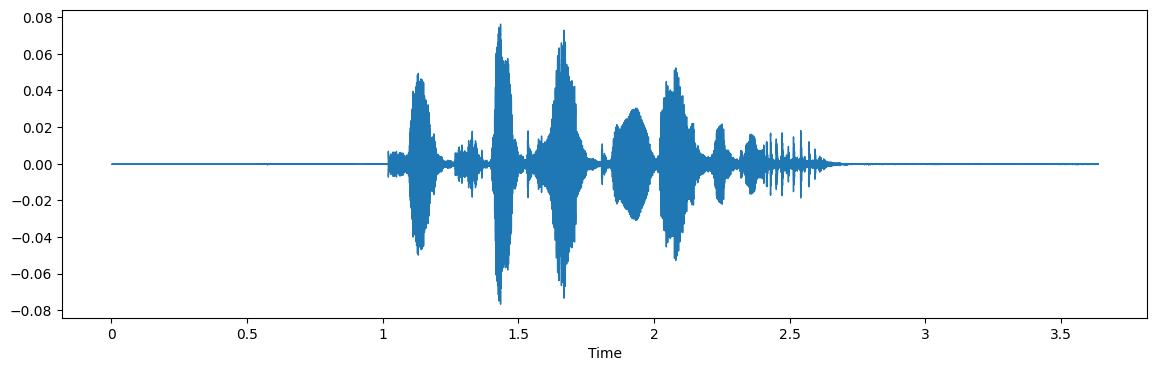

In [9]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

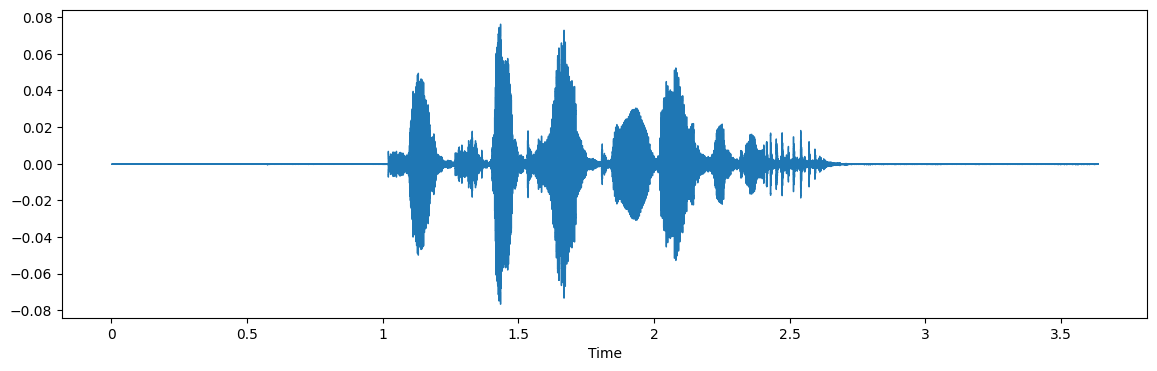

In [10]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

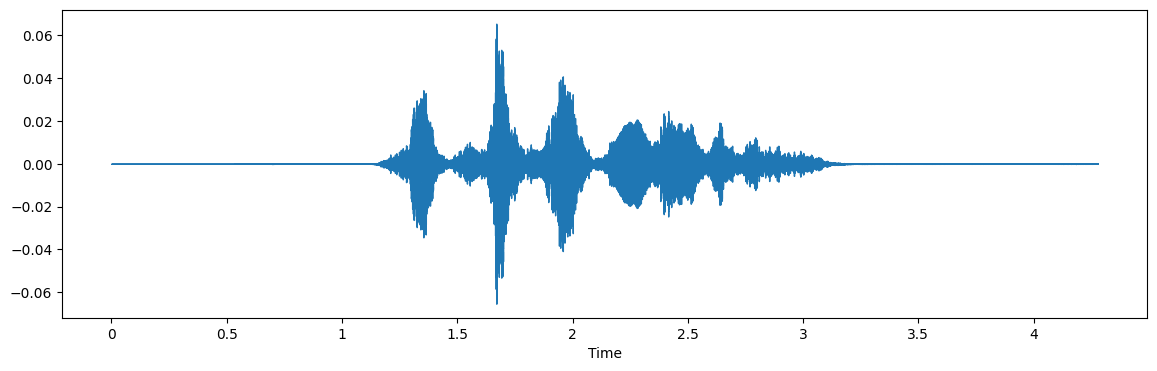

In [11]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

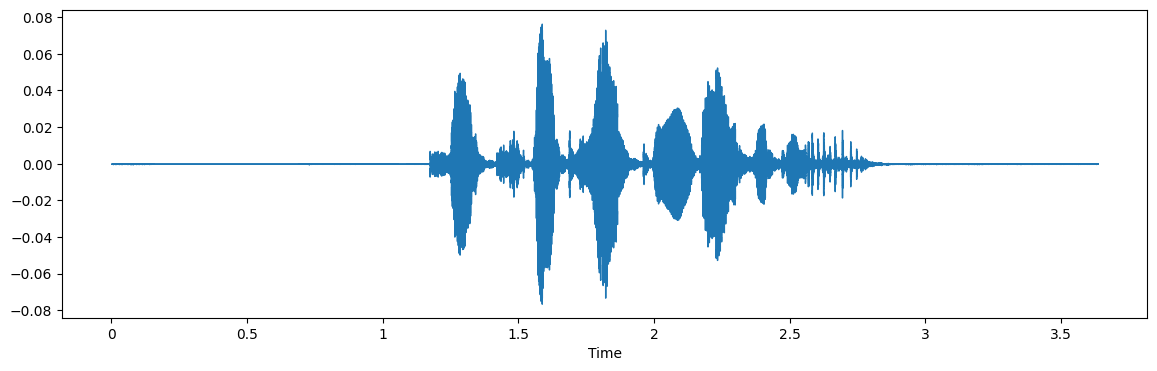

In [12]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

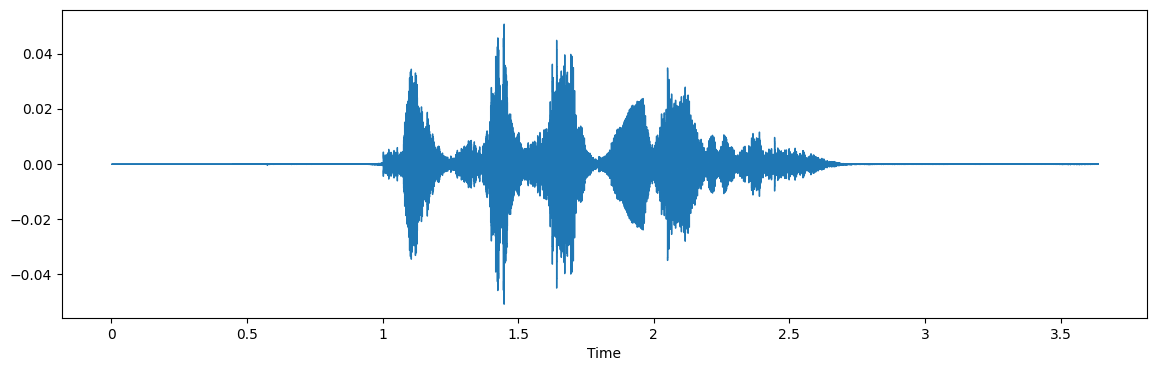

In [13]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [14]:
def extract_features(data):
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate)
    result = mfcc
    return result

def transform_audio(data, fns):
    fn = random.choice(fns)
    if fn == pitch:
        fn_data = fn(data, sampling_rate)
    elif fn == "None":
        fn_data = data
    elif fn in [noise, stretch]:
        fn_data = fn(data)
    else:
        fn_data = data
    return fn_data


def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    fns = [noise, pitch, "None"]

    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res1 = extract_features(fn2_data)
    result = [np.array(res1[:,:108])]

    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res2 = extract_features(fn2_data)[:,:108]
    result.append(res2)#np.vstack((result, res2)) # stacking vertically

    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res3 = extract_features(fn2_data)[:,:108]
    result.append(res3)#np.vstack((result, res3)) # stacking vertically

    return result

In [ ]:
path = "ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav"
data, sampling_rate = librosa.load(path, duration=2.5, offset=0.6)
Audio(path)
xx1 = librosa.feature.zero_crossing_rate(data)
stft = np.abs(librosa.stft(data))
xx2 = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
xx3 = librosa.feature.mfcc(y=data, sr=sample_rate)
xx4 = librosa.feature.rms(y=data)
xx5 = librosa.feature.melspectrogram(y=data, sr=sample_rate)
xx1.shape, xx2.shape, xx3.shape, xx4.shape, xx5.shape, np.append(xx1,xx2,axis=0).shape

((1, 108), (12, 108), (20, 108), (1, 108), (128, 108), (13, 108))

In [16]:
X, Y = [], []
for path, emotion in zip(data_path.Path.to_list(), data_path.Emotions.to_list()):
    feature = get_features(path)
    for ele in feature:
        if ele.shape == (20, 108):
            X.append(ele)
            Y.append(emotion)
        else:
            print(ele.shape)

(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 103)
(20, 103)
(20, 103)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 104)
(20, 104)
(20, 104)
(20, 101)
(20, 101)
(20, 101)
(20, 107)
(20, 107)
(20, 107)
(20, 105)
(20, 105)
(20, 105)
(20, 105)
(20, 105)
(20, 105)


In [17]:
len(X), len(Y), data_path.Path.shape

(4275, 4275, (1440,))

In [18]:
dfm = pd.DataFrame()
xx = pd.Series(X)
for i in range(20):
    dfm[i] = [k[i] for k in xx]

In [19]:
Features = dfm.copy()
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,"[-780.73065, -774.9925, -741.17993, -694.7276,...","[0.0, -4.0699563, -20.1089, -33.17015, -28.182...","[0.0, 2.6576629, 4.0471053, -8.056921, -26.875...","[0.0, -0.255769, 9.093172, 26.679684, 25.67638...","[0.0, 1.4697071, 5.6434317, 7.923846, 3.048751...","[0.0, 0.831396, -4.69526, -11.854406, -14.6898...","[0.0, -2.9131603, -11.304644, -18.668583, -18....","[0.0, 2.4352126, 2.4615648, -0.32879174, 3.804...","[0.0, 0.20111069, 3.032237, 6.555974, 10.81815...","[0.0, -0.880838, -2.2735026, -0.04242024, 4.44...",...,"[0.0, 1.4352553, 7.7916527, 7.6486473, 8.38967...","[0.0, 1.2625375, 11.050004, 17.091755, 22.3579...","[0.0, 0.631518, -1.6469905, 3.5436406, 7.92509...","[0.0, -1.3136809, -5.0513563, -5.1756487, -5.2...","[0.0, 5.351081, 15.503844, 14.269384, 7.205087...","[0.0, -2.303292, -3.3963099, -3.512868, -7.205...","[0.0, 1.4492881, -3.7543705, -5.5699883, -3.20...","[0.0, 0.29959, -2.0362034, -0.21473809, 2.8215...","[0.0, 0.2845315, 4.076214, 2.8159895, 8.292643...",surprise
1,"[-780.73065, -774.9925, -741.17993, -694.7276,...","[0.0, -4.0699563, -20.1089, -33.17015, -28.182...","[0.0, 2.6576629, 4.0471053, -8.056921, -26.875...","[0.0, -0.255769, 9.093172, 26.679684, 25.67638...","[0.0, 1.4697071, 5.6434317, 7.923846, 3.048751...","[0.0, 0.831396, -4.69526, -11.854406, -14.6898...","[0.0, -2.9131603, -11.304644, -18.668583, -18....","[0.0, 2.4352126, 2.4615648, -0.32879174, 3.804...","[0.0, 0.20111069, 3.032237, 6.555974, 10.81815...","[0.0, -0.880838, -2.2735026, -0.04242024, 4.44...",...,"[0.0, 1.4352553, 7.7916527, 7.6486473, 8.38967...","[0.0, 1.2625375, 11.050004, 17.091755, 22.3579...","[0.0, 0.631518, -1.6469905, 3.5436406, 7.92509...","[0.0, -1.3136809, -5.0513563, -5.1756487, -5.2...","[0.0, 5.351081, 15.503844, 14.269384, 7.205087...","[0.0, -2.303292, -3.3963099, -3.512868, -7.205...","[0.0, 1.4492881, -3.7543705, -5.5699883, -3.20...","[0.0, 0.29959, -2.0362034, -0.21473809, 2.8215...","[0.0, 0.2845315, 4.076214, 2.8159895, 8.292643...",surprise
2,"[-842.4293, -810.27386, -765.23456, -716.2716,...","[-0.7284156, -20.485247, -34.117905, -35.37328...","[1.1983293, 7.236995, 1.9692304, -12.551266, -...","[0.14264293, 6.5809526, 22.981224, 30.53946, 2...","[0.4873652, 4.3057566, 6.181902, 5.251587, 1.0...","[0.7579707, -3.7264495, -11.30093, -17.780743,...","[-0.13366581, -6.159686, -17.49778, -22.887836...","[1.1578057, 5.270319, 5.7176323, 7.7664356, 8....","[-0.055315584, 0.74628353, 5.01916, 10.5490265...","[0.74356323, -0.7635759, -3.2765546, 0.4484496...",...,"[0.58186567, 7.556935, 14.242044, 13.218136, 1...","[0.4482885, 7.5226736, 14.023125, 17.734337, 2...","[0.4087255, -4.76933, -3.625297, -0.061452627,...","[0.3204925, 1.3659843, -1.3990437, -3.0951312,...","[0.99149126, 12.400858, 15.080126, 9.737394, 6...","[-0.353041, -8.92068, -7.5903797, -8.916357, -...","[1.2132949, 2.3376703, -2.174104, 1.3368235, 7...","[-0.044540837, -1.1985681, -0.20614535, 2.9037...","[0.688397, 3.5744665, 3.510256, 0.3927817, 1.3...",surprise
3,"[-493.654149388446, -461.1423807831172, -474.9...","[-4.310844296861079, -3.8395685236726047, -0.9...","[-0.20084673747356885, 0.4862194811138043, 4.5...","[2.332837196105455, 3.8173691467523327, 7.1448...","[-8.728459730497711, -5.489636112532531, 0.232...","[3.0224938151566123, -0.5498944030736986, 3.12...","[-0.7976399483818779, -5.674674778905173, -4.8...","[-1.4800830875090394, -2.8606593931385937, -2....","[-8.660487606873481, -7.20554434204632, -4.877...","[1.3311770098283844, -0.3818923921543322, -1.8...",...,"[0.05028743312532935, 4.460777380179806, 4.890...","[-3.1618477688520037, 0.6638189249889772, 2.50...","[2.9683195970727154, 5.408869698261576, 4.2550...","[-0.9361988601099105, -4.763900235786789, -10....","[3.5587310780902124, -4.203076447771255, -6.88...","[-2.646336886937412, -4.686606058695585, -1.98...","[-0.6362249883766158, 5.41688409258502, 9.4002...","[1.4214214881018263, 4.740181025756566, 5

In [20]:
X = np.array(X)
Y = np.array(Y)
X.shape, Y.shape

((4275, 20, 108), (4275,))

In [21]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=21, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3420, 20, 108), (3420, 8), (855, 20, 108), (855, 8))

In [23]:
x_train = np.expand_dims(x_train, axis=3)
x_train = np.swapaxes(x_train, 1, 2)
# x_train = np.expand_dims(x_train, axis=3)

x_test = np.expand_dims(x_test, axis=3)
x_test = np.swapaxes(x_test, 1, 2)
# x_test = np.expand_dims(x_test, axis=3)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3420, 108, 20, 1), (3420, 8), (855, 108, 20, 1), (855, 8))

In [24]:
input_shape = x_train.shape[1:]
input_shape

(108, 20, 1)

In [25]:
from keras.models import Sequential
from keras.layers import TimeDistributed, Conv1D, BatchNormalization, Flatten, LSTM, Dropout, Dense, Bidirectional

model = Sequential()

# 1. Add more Conv1D layers and larger kernel sizes
model.add(TimeDistributed(Conv1D(32, 20, padding='same', activation='relu', data_format="channels_last"),
                          input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Conv1D(64, 10, padding='same', activation='relu', data_format="channels_last")))
model.add(TimeDistributed(BatchNormalization()))

# 2. Flattening layer
model.add(TimeDistributed(Flatten()))

# 3. Use Bidirectional LSTM with more units
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.5))

# 4. Dense Layer with more units
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=8, activation='softmax'))

# 6. Compile model with Adam optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 108, 20, 32)         │             672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 108, 20, 32)         │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 108, 20, 64)         │          20,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 108, 20, 64)         │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 108, 1280)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │         688,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 727,784 (2.78 MB)

 Trainable params: 727,592 (2.78 MB)

 Non-trainable params: 192 (768.00 B)

In [26]:
optimizer = Adam()
model.compile(optimizer=optimizer,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=4, min_lr=0.0000001)

epochs = 100
history = model.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 74s 649ms/step - accuracy: 0.1475 - loss: 2.1330 - val_accuracy: 0.1813 - val_loss: 2.0131 - learning_rate: 0.0010
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 374ms/step - accuracy: 0.1735 - loss: 2.0280 - val_accuracy: 0.2281 - val_loss: 1.9828 - learning_rate: 0.0010
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 372ms/step - accuracy: 0.1891 - loss: 1.9801 - val_accuracy: 0.2643 - val_loss: 1.9409 - learning_rate: 0.0010
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 373ms/step - accuracy: 0.2202 - loss: 1.9527 - val_accuracy: 0.2596 - val_loss: 1.8877 - learning_rate: 0.0010
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 375ms/step - accuracy: 0.2166 - loss: 1.9375 - val_accuracy: 0.2678 - val_loss: 1.8813 - learning_rate: 0.0010
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 375ms/step - accuracy: 0.2458 - loss: 1.8901 - val_accuracy: 0.3228 - val_loss: 1.8301 - learning_rate: 0.0010
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 376ms/step - accuracy: 0.2679 - l

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6544 - loss: 1.0666
Accuracy of our model on test data :  66.78362488746643 %


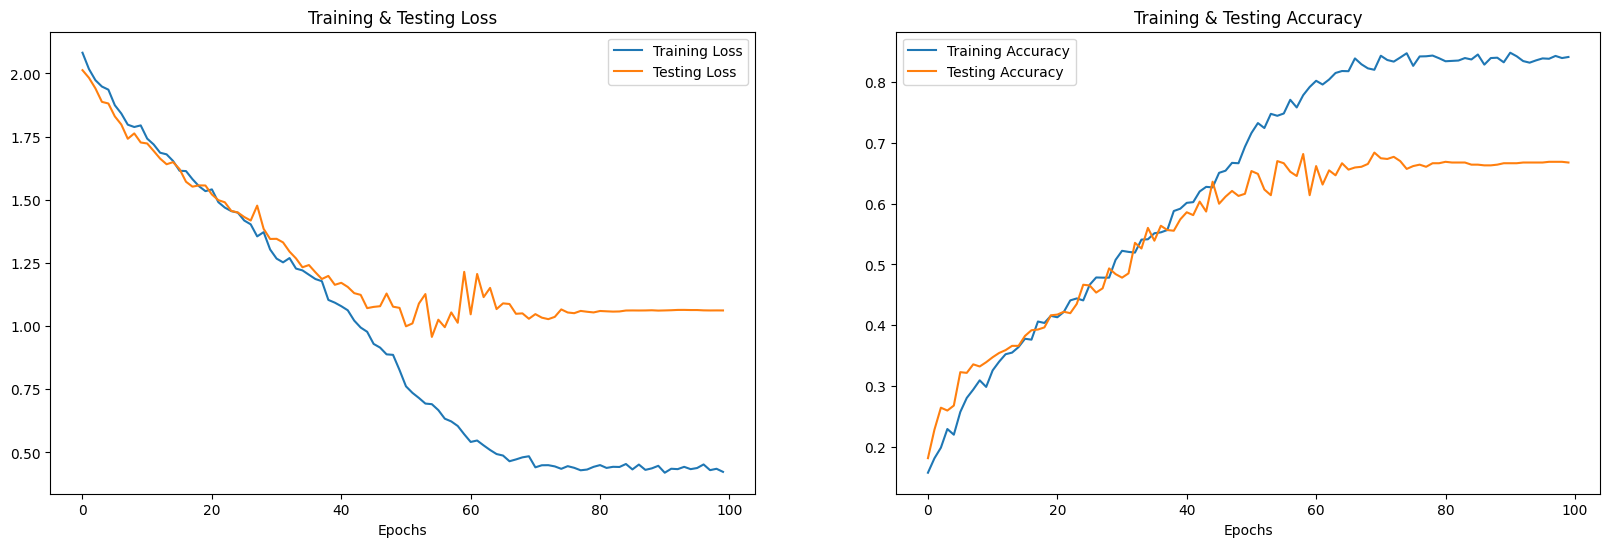

In [27]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [28]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 308ms/step


In [29]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,surprise,surprise
1,angry,disgust
2,angry,angry
3,angry,angry
4,fear,surprise
5,happy,happy
6,happy,fear
7,happy,happy
8,neutral,neutral
9,disgust,disgust


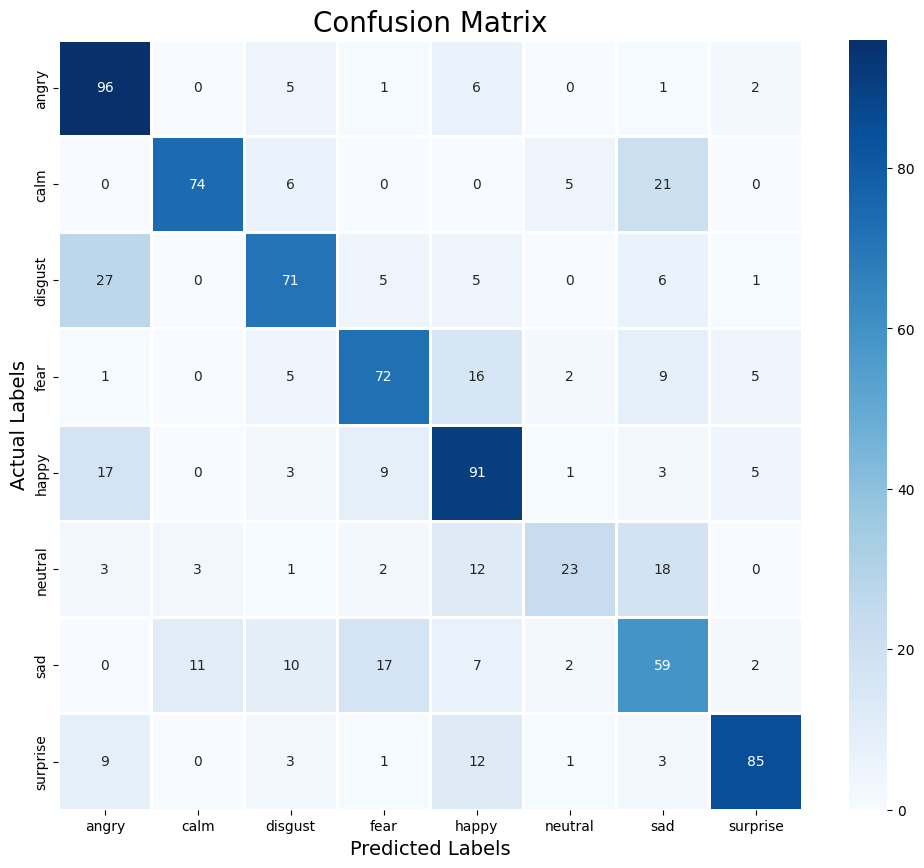

In [30]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.63      0.86      0.73       111
        calm       0.84      0.70      0.76       106
     disgust       0.68      0.62      0.65       115
        fear       0.67      0.65      0.66       110
       happy       0.61      0.71      0.65       129
     neutral       0.68      0.37      0.48        62
         sad       0.49      0.55      0.52       108
    surprise       0.85      0.75      0.79       114

    accuracy                           0.67       855
   macro avg       0.68      0.65      0.66       855
weighted avg       0.68      0.67      0.67       855



In [32]:
model.save("audio_emotion.h5")
import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)